In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy   as np
import sklearn as skl

import matplotlib.pyplot as plt
import seaborn           as srn

from sklearn.model_selection       import train_test_split
from sklearn.svm                   import OneClassSVM
from sklearn.kernel_approximation  import Nystroem
from sklearn.neighbors             import KernelDensity
from sklearn.model_selection       import GridSearchCV
from sklearn.metrics               import pairwise_distances
from scipy.stats                   import beta
import random
import numpy as np
import random
import numpy as np
import seaborn as sns, numpy as np
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import sys
from sklearn import svm
import time
import tensorflow as tf
from sklearn.metrics import precision_score,accuracy_score
import csv
from itertools import izip_longest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generate samples from a Beta(2, 2) distribution.

In [6]:
np.random.seed(42)
N = 10**4

X     = beta.rvs(a = 2, b = 2, size = N)[:,np.newaxis]
pStar = lambda x: beta.pdf(x, a = 2, b = 2)

XTr, XTe = train_test_split(X, train_size = 0.80, test_size = 0.20, random_state = 42)
XTe      = XTe[np.argsort(XTe.flatten()),:]

In [7]:
results = "./sanity_results/"
decision_scorePath = "./scores/"
df_usps_scores  = {}
activations = ["Linear","Sigmoid"]
methods = ["Linear","RBF"]
path = "/Users/raghav/Documents/Uni/NIPS-2018/experiments/scores/"


def write_Scores2Csv(train, trainscore, test, testscore,filename):

    data = np.concatenate((train, test))
    score= np.concatenate((trainscore,testscore))
    data = data.tolist()
    score = score.tolist()
    with open(filename, 'a') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(("x", "score"))
    for row in range(0,len(data)):
        with open(filename,
                  'a') as myfile:
            wr = csv.writer(myfile)

            wr.writerow((" ".join(str(x) for x in data[row]), " ".join(str(x) for x in score[row])))


def write_decisionScores2Csv(path, filename, positiveScores, negativeScores):

    newfilePath = path+filename
    print "Writing file to ", path+filename
    poslist = positiveScores.tolist()
    neglist = negativeScores.tolist()

    # rows = zip(poslist, neglist)
    d = [poslist, neglist]
    export_data = izip_longest(*d, fillvalue='')
    with open(newfilePath, 'w') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(("Normal", "Anomaly"))
        wr.writerows(export_data)
    myfile.close()

    return


def tf_OneClass_NN_sigmoid(data_train,data_test):

    tf.reset_default_graph()

    train_X = data_train

    RANDOM_SEED = 42
    tf.set_random_seed(RANDOM_SEED)

     # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
    h_size = 32                # Number of hidden nodes
    y_size = 1   # Number of outcomes (3 iris flowers)
    D = x_size
    K = h_size

    theta = np.random.normal(0, 1, K + K*D + 1)
    rvalue = np.random.normal(0,1,(len(train_X),y_size))
    nu = 0.1



    def init_weights(shape):
        """ Weight initialization """
        weights = tf.random_normal(shape,mean=0, stddev=0.00001)
        return tf.Variable(weights)

    def forwardprop(X, w_1, w_2):
        """
        Forward-propagation.
        IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
        """
        X = tf.cast(X, tf.float32)
        w_1 = tf.cast(w_1, tf.float32)
        w_2 = tf.cast(w_2, tf.float32)
        h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
        yhat = tf.matmul(h, w_2)  # The \varphi function
        return yhat

    g   = lambda x : 1/(1 + tf.exp(-x))

    def nnScore(X, w, V, g):
        X = tf.cast(X, tf.float32)
        w = tf.cast(w, tf.float32)
        V = tf.cast(V, tf.float32)
        return tf.matmul(g((tf.matmul(X, w))), V)

    def relu(x):
        y = x
    #     y[y < 0] = 0
        return y

    def ocnn_obj(theta, X, nu, w1, w2, g,r):

        w = w1
        V = w2


        X = tf.cast(X, tf.float32)
        w = tf.cast(w1, tf.float32)
        V = tf.cast(w2, tf.float32)


        term1 = 0.5  * tf.reduce_sum(w**2)
        term2 = 0.5  * tf.reduce_sum(V**2)
        term3 = 1/nu * tf.reduce_mean(relu(r - nnScore(X, w, V, g)))
        term4 = -r

        return term1 + term2 + term3 + term4


    # For testing the algorithm
    test_X = data_test


    # Symbols
    X = tf.placeholder("float32", shape=[None, x_size])

    r = tf.get_variable("r", dtype=tf.float32,shape=(),trainable=False)

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    w_2 = init_weights((h_size, y_size))

    # Forward propagation
    yhat    = forwardprop(X, w_1, w_2)
    predict = tf.argmax(yhat, axis=1)


    # Backward propagation
    # cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
    cost    = ocnn_obj(theta, X, nu, w_1, w_2, g,r)
    updates = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)
    # updates = tf.train.AdamOptimizer(4.7 * 1e-1).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    rvalue = 0.1
    start_time = time.time()
    for epoch in range(1000):
            # Train with each example
                sess.run(updates, feed_dict={X: train_X,r:rvalue})
                rvalue = nnScore(train_X, w_1, w_2, g)
                with sess.as_default():
                    rvalue = rvalue.eval()
                    rvalue = np.percentile(rvalue,q=100*0.04)
                print("Epoch = %d, r = %f"
                  % (epoch + 1,rvalue))

    trainTime = time.time() - start_time

    start_time = time.time()
    train = nnScore(train_X, w_1, w_2, g)
    test = nnScore(test_X, w_1, w_2, g)
    testTime = time.time() - start_time
    with sess.as_default():
        arrayTrain = train.eval()
        arrayTest = test.eval()
    #     rstar = r.eval()

    rstar =rvalue
    sess.close()
    print "Session Closed!!!"


    pos_decisionScore = arrayTrain-rstar
    neg_decisionScore = arrayTest-rstar

    write_Scores2Csv(train_X,pos_decisionScore,test_X,neg_decisionScore,path+"OC_NN.csv")

    write_decisionScores2Csv(decision_scorePath,"Synthetic_OC-NN_Sigmoid.csv",pos_decisionScore,neg_decisionScore)


    return [pos_decisionScore, neg_decisionScore,trainTime,testTime,rstar]

### Call OC-NN Sigmoid 

In [8]:
[train_decisionScore, test_decisionScore,trainTime,testTime,rstar_OCNN] = tf_OneClass_NN_sigmoid(XTr,XTe)

Epoch = 1, r = 0.007996
Epoch = 2, r = 0.015996
Epoch = 3, r = 0.023994
Epoch = 4, r = 0.031992
Epoch = 5, r = 0.039988
Epoch = 6, r = 0.047984
Epoch = 7, r = 0.055980
Epoch = 8, r = 0.063974
Epoch = 9, r = 0.071968
Epoch = 10, r = 0.079960
Epoch = 11, r = 0.087952
Epoch = 12, r = 0.095944
Epoch = 13, r = 0.103934
Epoch = 14, r = 0.111924
Epoch = 15, r = 0.119913
Epoch = 16, r = 0.127901
Epoch = 17, r = 0.135888
Epoch = 18, r = 0.143874
Epoch = 19, r = 0.151860
Epoch = 20, r = 0.159845
Epoch = 21, r = 0.167829
Epoch = 22, r = 0.175812
Epoch = 23, r = 0.183795
Epoch = 24, r = 0.191776
Epoch = 25, r = 0.199757
Epoch = 26, r = 0.207737
Epoch = 27, r = 0.215717
Epoch = 28, r = 0.223695
Epoch = 29, r = 0.231673
Epoch = 30, r = 0.239650
Epoch = 31, r = 0.247626
Epoch = 32, r = 0.255601
Epoch = 33, r = 0.263576
Epoch = 34, r = 0.271550
Epoch = 35, r = 0.279523
Epoch = 36, r = 0.287495
Epoch = 37, r = 0.295466
Epoch = 38, r = 0.303437
Epoch = 39, r = 0.311407
Epoch = 40, r = 0.319376
Epoch = 4

Epoch = 321, r = 2.528511
Epoch = 322, r = 2.536269
Epoch = 323, r = 2.544027
Epoch = 324, r = 2.551783
Epoch = 325, r = 2.559539
Epoch = 326, r = 2.567295
Epoch = 327, r = 2.575049
Epoch = 328, r = 2.582803
Epoch = 329, r = 2.590556
Epoch = 330, r = 2.598309
Epoch = 331, r = 2.606060
Epoch = 332, r = 2.613811
Epoch = 333, r = 2.621562
Epoch = 334, r = 2.629311
Epoch = 335, r = 2.637060
Epoch = 336, r = 2.644809
Epoch = 337, r = 2.652556
Epoch = 338, r = 2.660303
Epoch = 339, r = 2.668049
Epoch = 340, r = 2.675795
Epoch = 341, r = 2.683540
Epoch = 342, r = 2.691284
Epoch = 343, r = 2.699027
Epoch = 344, r = 2.706769
Epoch = 345, r = 2.714512
Epoch = 346, r = 2.722253
Epoch = 347, r = 2.729993
Epoch = 348, r = 2.737733
Epoch = 349, r = 2.745472
Epoch = 350, r = 2.753210
Epoch = 351, r = 2.760948
Epoch = 352, r = 2.768685
Epoch = 353, r = 2.776422
Epoch = 354, r = 2.784157
Epoch = 355, r = 2.791892
Epoch = 356, r = 2.799626
Epoch = 357, r = 2.807360
Epoch = 358, r = 2.815093
Epoch = 359,

Epoch = 637, r = 4.946231
Epoch = 638, r = 4.953779
Epoch = 639, r = 4.961325
Epoch = 640, r = 4.968872
Epoch = 641, r = 4.976418
Epoch = 642, r = 4.983962
Epoch = 643, r = 4.991507
Epoch = 644, r = 4.999051
Epoch = 645, r = 5.006594
Epoch = 646, r = 5.014136
Epoch = 647, r = 5.021678
Epoch = 648, r = 5.029220
Epoch = 649, r = 5.036761
Epoch = 650, r = 5.044300
Epoch = 651, r = 5.051840
Epoch = 652, r = 5.059379
Epoch = 653, r = 5.066917
Epoch = 654, r = 5.074454
Epoch = 655, r = 5.081992
Epoch = 656, r = 5.089528
Epoch = 657, r = 5.097063
Epoch = 658, r = 5.104598
Epoch = 659, r = 5.112132
Epoch = 660, r = 5.119666
Epoch = 661, r = 5.127200
Epoch = 662, r = 5.134733
Epoch = 663, r = 5.142264
Epoch = 664, r = 5.149795
Epoch = 665, r = 5.157327
Epoch = 666, r = 5.164857
Epoch = 667, r = 5.172387
Epoch = 668, r = 5.179915
Epoch = 669, r = 5.187443
Epoch = 670, r = 5.194971
Epoch = 671, r = 5.202498
Epoch = 672, r = 5.210024
Epoch = 673, r = 5.217550
Epoch = 674, r = 5.225075
Epoch = 675,

Epoch = 953, r = 7.301378
Epoch = 954, r = 7.308741
Epoch = 955, r = 7.316102
Epoch = 956, r = 7.323463
Epoch = 957, r = 7.330823
Epoch = 958, r = 7.338183
Epoch = 959, r = 7.345541
Epoch = 960, r = 7.352900
Epoch = 961, r = 7.360258
Epoch = 962, r = 7.367615
Epoch = 963, r = 7.374972
Epoch = 964, r = 7.382328
Epoch = 965, r = 7.389685
Epoch = 966, r = 7.397039
Epoch = 967, r = 7.404394
Epoch = 968, r = 7.411748
Epoch = 969, r = 7.419102
Epoch = 970, r = 7.426455
Epoch = 971, r = 7.433807
Epoch = 972, r = 7.441159
Epoch = 973, r = 7.448510
Epoch = 974, r = 7.455861
Epoch = 975, r = 7.463212
Epoch = 976, r = 7.470562
Epoch = 977, r = 7.477911
Epoch = 978, r = 7.485260
Epoch = 979, r = 7.492607
Epoch = 980, r = 7.499955
Epoch = 981, r = 7.507302
Epoch = 982, r = 7.514648
Epoch = 983, r = 7.521995
Epoch = 984, r = 7.529340
Epoch = 985, r = 7.536685
Epoch = 986, r = 7.544029
Epoch = 987, r = 7.551373
Epoch = 988, r = 7.558716
Epoch = 989, r = 7.566059
Epoch = 990, r = 7.573401
Epoch = 991,

In [19]:
print "r-star: OC-NN",rstar_OCNN 

r-star: OC-NN 7.64679281235


Plot the true density, the 10% quantile threshold for the density, and the OC-SVM predictions.

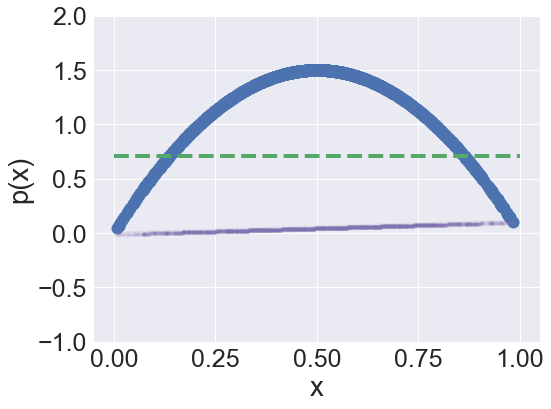

In [17]:
srn.set(font_scale = 2.5);
plt.figure(figsize = (8,6));

rStar = np.percentile(pStar(XTe), q = 100 * 0.10)

plt.plot(XTe, pStar(XTe),                        '.-', linewidth=8, markersize=24);
plt.plot([0,1], [rStar,rStar],                   '--', linewidth=4, markersize=24);
plt.plot([0,1], [rstar_OCNN,rstar_OCNN],         '-.', linewidth=4, markersize=24);
plt.plot(XTe, test_decisionScore,      '.-', linewidth=6, markersize=8, alpha=0.125);
plt.ylim((-1, 2))
plt.xlabel('x'); plt.ylabel('p(x)');
plt.savefig('beta_test.pdf', bbox_inches = 'tight');